#  import kit

In [1]:
import sys
from pathlib import Path
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT / "src"))

In [17]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from PEC_sampler_package_teleportation import tele_PEC_Readout_Module_Sampler as pecro
from PEC_sampler_package_teleportation import tele_PEC_TQG_Module_Sampler as peccx
from PEC_sampler_package_teleportation import tele_PEC_sampler as pec
from PEC_sampler_package_teleportation import tele_Restore_Retrieve as RR
import tele_Fidelity as fdlt

import qiskit as q
from qiskit import QuantumCircuit
from qiskit.visualization import *
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
name = "torino"
device_name = "ibm_" + name
QiskitRuntimeService.save_account(
        channel="ibm_quantum_platform",
        token=token,
        instance=instance,
        set_as_default=True,
        overwrite=True
    )
service = QiskitRuntimeService()
device = service.backend(device_name)
noise_model = NoiseModel.from_backend(device)

In [4]:
backend = AerSimulator.from_backend(device)
backend_options = {
    # "method": "automatic",
    "noise_model": noise_model,
    "basis_gates": noise_model.basis_gates,
    "coupling_map": device.configuration().coupling_map,
    # parallelism knobs
    # "max_parallel_experiments":32,
    # "max_parallel_threads": 0
    # "device": "GPU",  # if you have qiskit-aer-gpu
}
run_options = {
    "shots": 1024,
    # "seed_simulator": 12345,
}

sampler = SamplerV2(
    options={
        "backend_options": backend_options,
        "run_options": run_options,
        # "default_precision": 0.0,  # if you want deterministic path where applicable
    }
)
sampler.mode=backend
backendqubitNum = backend.num_qubits
print(backendqubitNum)

133


# Build Teleportation Circuit

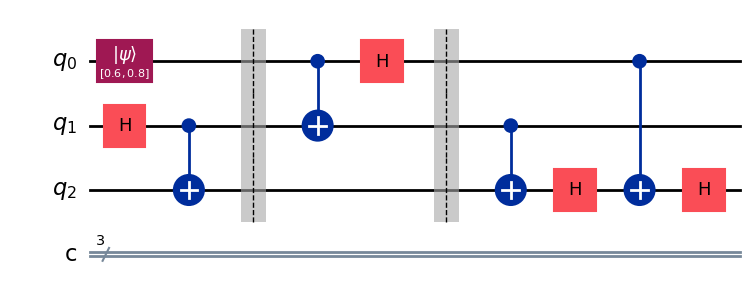

In [ ]:
tele = QuantumCircuit(3, 3)

# State preparation 
a = 0.6; b = 0.8
tele.initialize([a, b], 0)
tele.h(1)
tele.cx(1, 2)
tele.barrier()

# Teleportation circuit
tele.cx(0, 1)
tele.h(0)
# tele.measure([0, 1], [0, 1])
tele.barrier()
tele.cx(1, 2)
tele.h(2)
tele.cx(0, 2)
tele.h(2)
# tele.cx(1, 2).c_if(tele.clbits[1], 1)
# tele.cz(0, 2).c_if(tele.clbits[0], 1)
tele.draw('mpl')

# Pure State Analysis

In [ ]:
tele.measure(2, 2)
# backend = AerSimulator()
shots = 1024
result = backend.run(tele, shots=shots).result()
datas = result.data()["counts"]
datas

{'0x1': 103,
 '0x5': 157,
 '0x0': 71,
 '0x2': 104,
 '0x6': 175,
 '0x4': 148,
 '0x3': 106,
 '0x7': 160}

In [20]:
odd = 0; even = 0
for measurement, count in datas.items():
    if int(measurement, 16) <= 3 : even += count
    else: odd += count
a2 = np.sqrt(even/shots); b2 = np.sqrt(odd/shots)
print("coefzero:", a2, " ; coefone:", b2)
print("psi0ratio:", (a/b)**2, " ; psi2ratio:", even/odd)
print("fidelity:", (a*a2 + b*b2)**2)

coefzero: 0.6123724356957945  ; coefone: 0.7905694150420949
psi0ratio: 0.5624999999999999  ; psi2ratio: 0.6
fidelity: 0.9997580015448903


# Mix State Analysis

In [21]:
def add_observables(circuit, obs):
    tele = {}
    for o in obs:
        cir = circuit.copy()
        if o == "x":
            cir.h(2)           
        elif o == "y":
            cir.sdg(2)
            cir.h(2)
        cir.measure(2, 2)
        tele.update({o: cir})
    return tele

def expectaion(datas, shots):
    countq2zero=0
    for measurement, count in datas.items():
        if int(measurement, 16) <= 3 : countq2zero += count
    return 2*(countq2zero/shots)-1

def fidelity(psi0, psi1, rho):
    norm = np.sqrt(abs(a)**2 + abs(b)**2)
    na, nb = a/norm, b/norm

    # Bloch vector of |psi>
    sx = 2*np.real(np.conj(na)*nb)
    sy = 2*np.imag(np.conj(na)*nb)
    sz = abs(na)**2 - abs(nb)**2

    F = (1 + sx*rho["x"] + sy*rho["y"] + sz*rho["z"])/2
    return F

obs = ["x", "y", "z"]
telecirset = add_observables(tele, obs)
# backend = AerSimulator()
shots = 1024
rho = {}
for obs, telecir in telecirset.items():
    transtele = q.transpile(telecir, backend=backend)
    result = backend.run(transtele, shots=shots).result()
    datas = result.data()["counts"]
    expectaion_value = expectaion(datas, shots)
    rho.update({obs:expectaion_value})
    print(f"{obs}_count:", datas)
    print(f"{obs}_expectation:", expectaion_value)
fidelity_value = fidelity(a, b, rho)
print("Fidelity:", fidelity_value)

x_count: {'0x4': 46, '0x0': 978}
x_expectation: 0.91015625
y_count: {'0x0': 479, '0x4': 545}
y_expectation: -0.064453125
z_count: {'0x4': 655, '0x0': 369}
z_expectation: -0.279296875
Fidelity: 0.9759765624999999


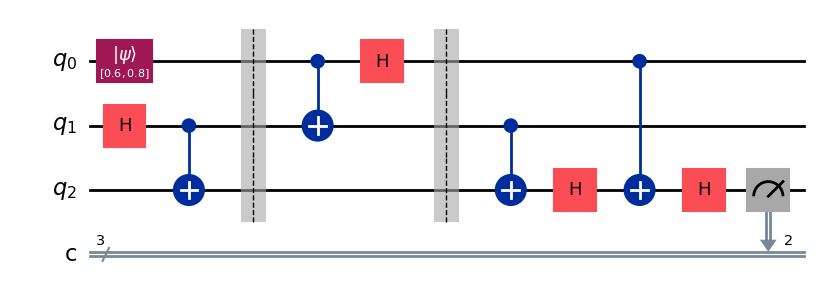

In [22]:
telecirset['z'].draw('mpl')

# Calculate Readout PEC Observable

In [24]:
importlib.reload(pecro)
pec_readout_info = pecro.readout_pec_sampler_subsystem(tele, sampler, backend, shots=1024, batch_mode=True, backend_options=backend_options)

Batch mode: single process, batch circuits per measurement.
III: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IIX: [0.0078125, -0.0078125, 0.884765625, -0.001953125, 0.00390625, -0.021484375, 0.880859375, -0.025390625, -0.029296875, -0.03515625, 0.875, 0.0, 0.056640625, -0.013671875, 0.865234375, 0.0234375, -0.05078125, 0.001953125, 0.859375, 0.017578125, -0.029296875, 0.01171875, 0.890625, -0.015625, 0.01171875, -0.048828125, 0.8671875, 0.013671875, -0.029296875, 0.01171875, 0.8671875, -0.001953125, 0.0234375, 0.001953125, 0.853515625, -0.02734375, 0.05078125, 0.048828125, 0.8671875, -0.01171875, 0.0390625, 0.013671875, 0.86328125, 0.03125, -0.044921875, 0.009765625, 0.890625, -0.037109375, -0.05859375, -0.005859375, 0

In [5]:
# RR.save_readout_result(pec_readout_info, fname="Oweights", parent_dir="ROWeight")
pec_readout_info = RR.load_readout_result("ROWeight/20251126-144853/Oweights.pkl")

In [20]:
B = pec_readout_info["B"]
readout_weights = pec_readout_info["ReadoutWeight"]
print("B:", B, "\nReadoutWeight:", readout_weights)

B: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.04980469e-02  8.89404297e-01  4.15039062e-03 ...  2.68554688e-03
  -8.54492188e-03  2.44140625e-04]
 [-2.68554688e-03 -1.68457031e-02  8.77685547e-01 ...  3.05175781e-02
   1.78222656e-02  4.63867188e-03]
 ...
 [ 1.41601562e-02  4.88281250e-03 -2.29492188e-02 ...  6.17675781e-01
   3.02734375e-02 -1.75781250e-02]
 [ 2.07519531e-02 -2.75878906e-02 -1.58691406e-02 ... -1.14746094e-02
   6.00830078e-01 -7.32421875e-04]
 [ 1.78222656e-02 -2.27050781e-02 -3.58886719e-02 ...  1.78222656e-02
  -1.39160156e-02  5.89111328e-01]] 
ReadoutWeight: {'III': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'IIX': array([[ 1.31040288e-02,  1.11130136e+0

# Calculate CNOT PEC Weight

In [11]:
importlib.reload(peccx)
pack = peccx.compute_tqg_matrices(sampler, tele, shots=1024, obs_batch=1024)

num_qubits: 3
(c1,t2) 1/64 (active=[0, 1, 2])
(c1,t2) 2/64 (active=[0, 1, 2])
(c1,t2) 3/64 (active=[0, 1, 2])
(c1,t2) 4/64 (active=[0, 1, 2])
(c1,t2) 5/64 (active=[0, 1, 2])
(c1,t2) 6/64 (active=[0, 1, 2])
(c1,t2) 7/64 (active=[0, 1, 2])
(c1,t2) 8/64 (active=[0, 1, 2])
(c1,t2) 9/64 (active=[0, 1, 2])
(c1,t2) 10/64 (active=[0, 1, 2])
(c1,t2) 11/64 (active=[0, 1, 2])
(c1,t2) 12/64 (active=[0, 1, 2])
(c1,t2) 13/64 (active=[0, 1, 2])
(c1,t2) 14/64 (active=[0, 1, 2])
(c1,t2) 15/64 (active=[0, 1, 2])
(c1,t2) 16/64 (active=[0, 1, 2])
(c1,t2) 17/64 (active=[0, 1, 2])
(c1,t2) 18/64 (active=[0, 1, 2])
(c1,t2) 19/64 (active=[0, 1, 2])
(c1,t2) 20/64 (active=[0, 1, 2])
(c1,t2) 21/64 (active=[0, 1, 2])
(c1,t2) 22/64 (active=[0, 1, 2])
(c1,t2) 23/64 (active=[0, 1, 2])
(c1,t2) 24/64 (active=[0, 1, 2])
(c1,t2) 25/64 (active=[0, 1, 2])
(c1,t2) 26/64 (active=[0, 1, 2])
(c1,t2) 27/64 (active=[0, 1, 2])
(c1,t2) 28/64 (active=[0, 1, 2])
(c1,t2) 29/64 (active=[0, 1, 2])
(c1,t2) 30/64 (active=[0, 1, 2])
(c1,t

KeyboardInterrupt: 

In [28]:
pec_tqg_info = peccx.averaged_pauli_twirling_matrix(pack, B=pec_readout_info["B"])
tqg_weights = peccx.compute_inv_weights_for_package(pec_tqg_info)
tqg_weights

{(1,
  2): array([ 7.52099876e-01,  2.38878683e-01, -2.30589168e-03, -1.22358109e-02,
         1.36303942e-02,  5.45406064e-03,  2.50618592e-01, -2.50413959e-01,
        -4.35458884e-03, -7.78764368e-03, -2.42970475e-01,  2.52148378e-01,
         2.61250468e-01, -2.37017111e-01,  3.92934249e-03,  9.25665875e-03,
        -2.20483592e-03, -1.34860056e-03,  2.96703975e-03,  5.90642897e-03,
        -1.06101031e-03, -6.91699737e-03, -8.90545582e-03,  5.16104356e-03,
         8.11154221e-03,  8.61536056e-03,  1.02222074e-02, -6.39291881e-03,
        -1.04718154e-02,  4.69267627e-03,  1.92524959e-03,  2.20889220e-03,
         4.78344755e-03,  3.16657309e-03,  4.85788269e-03, -2.84393278e-03,
         7.10028655e-03,  1.38696699e-02,  1.35476330e-02, -6.33905701e-03,
        -5.01093346e-03, -1.32920888e-02, -1.64261641e-02,  3.21674412e-04,
         5.67383033e-03, -1.00124525e-02, -3.34946311e-03, -5.43597939e-03,
         8.40035777e-03,  1.01105616e-02,  4.91064737e-03,  1.37066717e-02,
  

In [29]:
RR.save_vectors(tqg_weights, fname="Gweights", parent_dir="TQGWeight")

{'dir': 'TQGWeight/20251126-172221',
 'npy': 'TQGWeight/20251126-172221/Gweights.npy',
 'npz': 'TQGWeight/20251126-172221/Gweights.npz',
 'csv_list': ['TQGWeight/20251126-172221/Gweights_c0_t1.csv',
  'TQGWeight/20251126-172221/Gweights_c0_t2.csv',
  'TQGWeight/20251126-172221/Gweights_c1_t2.csv'],
 'meta_json': 'TQGWeight/20251126-172221/Gweights_meta.json',
 'mat': 'TQGWeight/20251126-172221/Gweights.mat'}

In [9]:
load_weights = RR.load_vectors("TQGWeight/20251126-172221/Gweights.npy")
tqg_weights = load_weights["vectors"]
tqg_weights

{(0,
  1): array([ 7.49475514e-01,  1.51197488e-02, -5.87153467e-04,  5.14544428e-03,
         2.47865451e-01, -4.60016170e-03,  1.47981377e-02,  5.19333053e-03,
        -2.04744418e-03, -8.20349751e-03,  4.85576918e-03,  3.01827159e-04,
        -6.74156489e-03,  4.69238584e-03,  2.81298423e-03,  3.54746378e-03,
        -1.81970955e-03,  1.57824826e-02, -2.81541087e-03, -5.32792882e-03,
        -1.66208273e-02, -6.58767882e-03,  6.44564381e-03,  8.65352223e-03,
         2.39156301e-01, -2.03730401e-02,  7.20572170e-03,  4.60031099e-03,
        -2.52353289e-01,  1.00966482e-02,  1.82947919e-03, -3.01533224e-03,
         4.66427313e-03, -6.79200647e-03, -4.87197708e-03, -5.62113156e-04,
         2.20593564e-02,  6.95654275e-03, -5.11636779e-03, -1.49408857e-02,
        -2.45519018e-01,  1.55555814e-02, -2.75221102e-03,  3.75493029e-04,
         2.50964256e-01, -9.41085994e-03, -9.23501438e-04,  7.02492106e-03,
         2.52929535e-01, -8.88253615e-03, -5.26725924e-03, -1.11973343e-02,
  

In [22]:
importlib.reload(pec)
importlib.reload(fdlt)
importlib.reload(RR)

<module 'PEC_sampler_package_teleportation.tele_Restore_Retrieve' from '/home/xiaonan/PEC/src/PEC_sampler_package_teleportation/tele_Restore_Retrieve.py'>

In [ ]:
# 2) 你的 readout 與 TQG 權重
# readout_weight: {'XX': w_vec(16), 'ZX': ..., 'XZ': ..., 'ZZ': ...}
# weights_map_tqg: {(c,t): np.ndarray length 4^n}  (n=電路總 qubits；或 m=active 也行，只要一致)
state = [a, b]
n_trials=10
S_pec, S_nopec, summary, meas_pec, meas_nopec = fdlt.compare_pec_vs_nopec_sampler(
    sampler=sampler,
    state=state,
    tqg_weights=tqg_weights,
    readout_weights=readout_weights,
    n_trials=n_trials,
    backend=backend,
    opt_level=0,
    shots=1024,
    combo_batch_size=256,
    max_batch=4096
)

print("=== Summary over trials ===")
print(summary)

[1/10]  S(noPEC)=0.95019531
[2/10]  S(noPEC)=0.92062500
[3/10]  S(noPEC)=0.93578125
[4/10]  S(noPEC)=0.93722656
[5/10]  S(noPEC)=0.93628906
[6/10]  S(noPEC)=0.92703125
[7/10]  S(noPEC)=0.94394531
[8/10]  S(noPEC)=0.93445312
[9/10]  S(noPEC)=0.93812500
[10/10]  S(noPEC)=0.92519531


QiskitError: 'Keyboard interrupt in parallel_map.'

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7df1d066f250>>
Traceback (most recent call last):
  File "/usr/local/miniconda3/envs/qiskit1.0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: Exception ignored in: Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7df1d066f250>><bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7df1d066f250>>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/miniconda3/envs/qiskit1.0/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
<bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7df1d06

In [ ]:
experiment_results={
    "S_pec": S_pec,
    "S_nopec": S_nopec,
    "summary": summary,
    "meas_pec": meas_pec,
}
RR.save_experiment_results(experiment_results, fname = "teleportation", parent_dir = "fidelity_results")
# with open("BellState_results/20251118-114007/bellstate.pkl", "rb") as f: data = pickle.load(f)
print(experiment_results)

Saved to: BellState_results/20251122-143516/bellstate.pkl
{'S_pec': array([2.71443085, 2.81144516, 2.71140902, 2.80767274, 2.81718417,
       2.864715  , 2.83697267, 2.86593928, 2.66537007, 2.75140543,
       2.7753139 , 2.83527333, 2.90866878, 2.77560232, 2.72795601,
       2.76602792, 2.72833109, 2.76768061, 2.68868094, 2.74708272,
       2.74959641, 2.81193961, 2.87340154, 2.79705247, 2.7294366 ,
       2.81453158, 2.74188113, 2.80412616, 2.83745833, 2.84139602,
       2.63637802, 2.8581356 , 2.78688618, 2.76996483, 2.88619022,
       2.84153388, 2.71563532, 2.86631458, 2.80702137, 2.83340018,
       2.91041774, 2.86486721, 2.79539443, 2.94397432, 2.78100215,
       2.83142675, 2.78486015, 2.76395984, 2.70852498, 2.76435729,
       2.83226548, 2.91171823, 2.88434299, 2.78664174, 2.74541046,
       2.83916472, 2.8889958 , 2.8304597 , 2.78930676, 2.71962168,
       2.70702205, 2.67949405, 2.89233465, 2.83356439, 2.84268564,
       2.86993743, 2.81269147, 2.76591968, 2.80521014, 2.7236

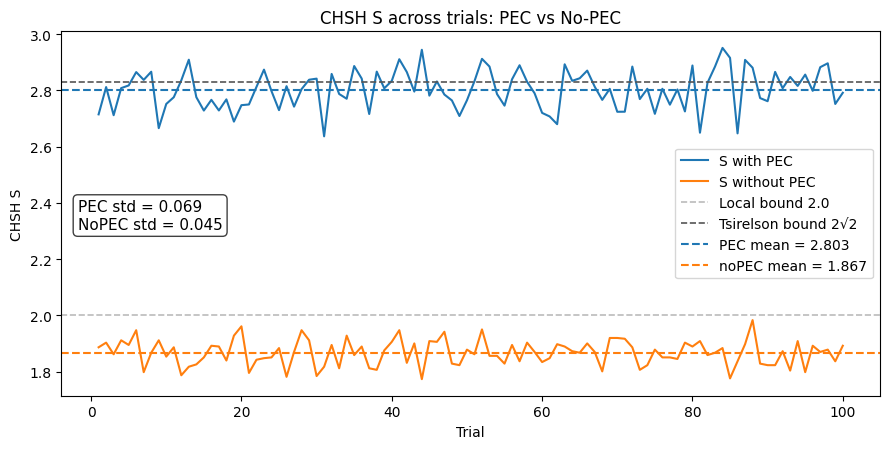

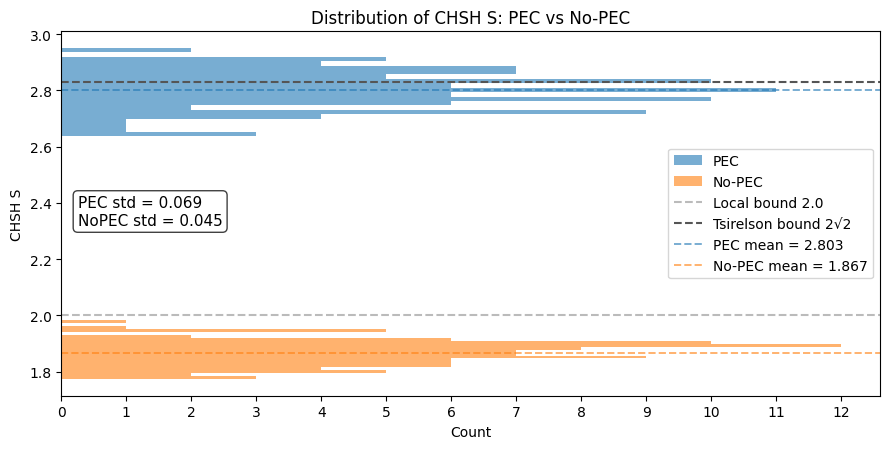

[SAVE] CHSH_trial → output_graph/20251122-143516_100/CHSH_trial.png
[SAVE] CHSH_distribution → output_graph/20251122-143516_100/CHSH_distribution.png


In [127]:
# ======  畫圖：折線 + 兩條平均線；以及分布（直方圖） ======
dark_gray = "#555555"  
light_gray = "#bbbbbb"
# 折線圖（每次 trial 的 S 值）
plt.figure(figsize=(9,4.6))
fig_trial = plt.gcf() 
line_pec, = plt.plot(range(1, n_trials+1), S_pec, label="S with PEC")
line_nopec, = plt.plot(range(1, n_trials+1), S_nopec, label="S without PEC")
plt.axhline(2.0, linestyle="--", linewidth=1.2, color=light_gray, label="Local bound 2.0")
plt.axhline(2*np.sqrt(2), linestyle="--", linewidth=1.2, color=dark_gray, label="Tsirelson bound 2√2")
plt.axhline(summary["PEC_mean"], linestyle="--", color=line_pec.get_color(), label=f"PEC mean = {summary['PEC_mean']:.3f}")
plt.axhline(summary["noPEC_mean"], linestyle="--", color=line_nopec.get_color(), label=f"noPEC mean = {summary['noPEC_mean']:.3f}")
plt.xlabel("Trial")
plt.ylabel("CHSH S")
plt.title("CHSH S across trials: PEC vs No-PEC")
textstr = (
    f"PEC std = {summary['PEC_std']:.3f}\n"
    f"NoPEC std = {summary['noPEC_std']:.3f}"
)
plt.gca().text(
    0.02, 0.45, textstr,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.75)
)
plt.legend()
plt.tight_layout()
plt.show()

# 直方圖（分布比較）
plt.figure(figsize=(9,4.6))
fig_dist = plt.gcf() 
n_pec, bins_pec, patches_pec = plt.hist(S_pec, bins=max(10, n_trials//5), alpha=0.6, label="PEC", orientation="horizontal")
n_nopec, bins_nopec, patches_nopec = plt.hist(S_nopec, bins=max(10, n_trials//5), alpha=0.6, label="No-PEC", orientation="horizontal")
plt.axhline(2.0, linestyle="--", color=light_gray, label="Local bound 2.0")
plt.axhline(2*np.sqrt(2), linestyle="--", color=dark_gray, label="Tsirelson bound 2√2")
plt.axhline(summary["PEC_mean"], linestyle="--", color=patches_pec[0].get_facecolor(), linewidth=1.4, label=f"PEC mean = {summary['PEC_mean']:.3f}")
plt.axhline(summary["noPEC_mean"], linestyle="--", color=patches_nopec[0].get_facecolor(), linewidth=1.4, label=f"No-PEC mean = {summary['noPEC_mean']:.3f}")
max_count = int(max(n_pec.max(), n_nopec.max()))
plt.xticks(range(max_count + 1))
plt.xlabel("Count")
plt.ylabel("CHSH S")
plt.title("Distribution of CHSH S: PEC vs No-PEC")
textstr = (
    f"PEC std = {summary['PEC_std']:.3f}\n"
    f"NoPEC std = {summary['noPEC_std']:.3f}"
)
plt.gca().text(
    0.02, 0.55, textstr,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.75)
)
plt.legend()
plt.tight_layout()
plt.show()
save_dir = RR.save_chsh_figures(fig_trial, fig_dist, n_trials, parent_dir="output_graph")